In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
import numba
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pydvs.numba_nvs import *

funcs = [
    nvs_0, 
    nvs_leaky, 
    nvs_leaky_adaptive, 
    nvs_noisy_leaky_adaptive,
    nvs_bi_noisy_leaky_adaptive
]

txt = [
    "perfect",
    "leaky",
    "L+Adaptive",
    "L+A+Noisy Leak",
    "2Cell+NLA",
]

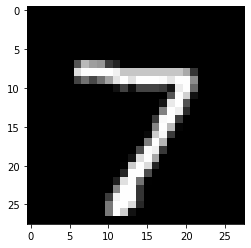

In [3]:
img_path = 'mnist/t10k/t10k-images-idx3-ubyte__idx_000__lbl_7_.png'
img = cv2.imread(img_path,0).astype('float32')
plt.figure()
plt.imshow(img, cmap='gray')
plt.show()
vmin = 0.
vmax = img.max() 
print()

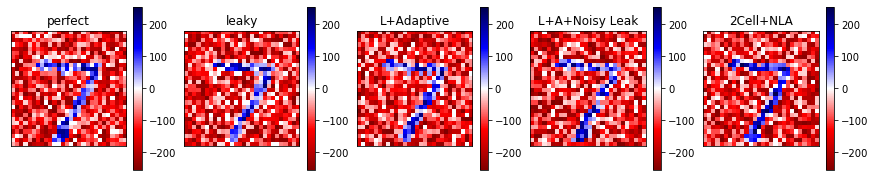

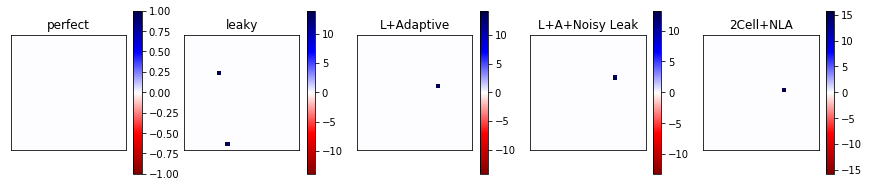

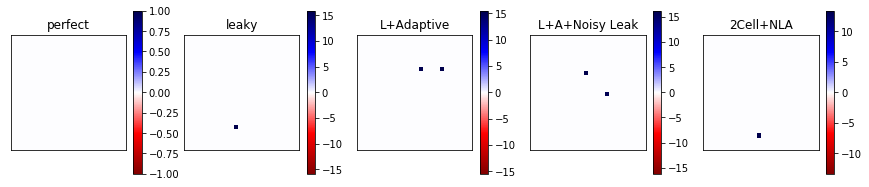

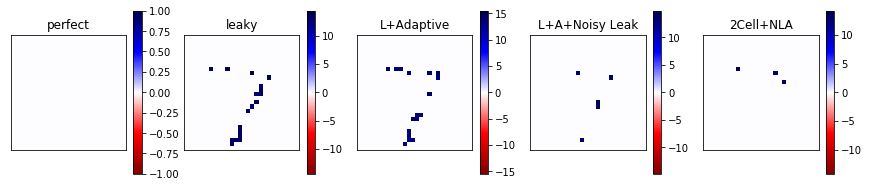

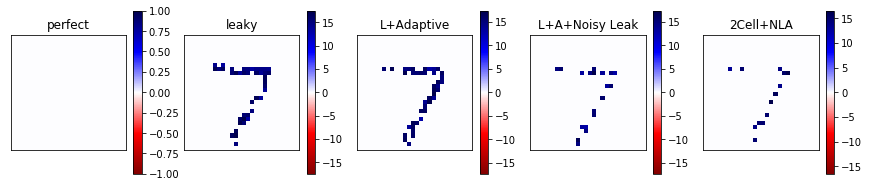

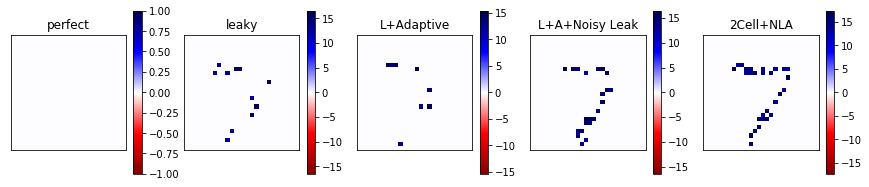

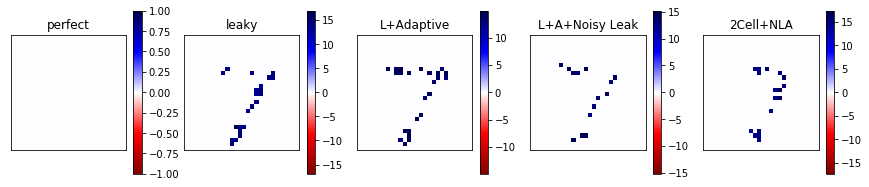

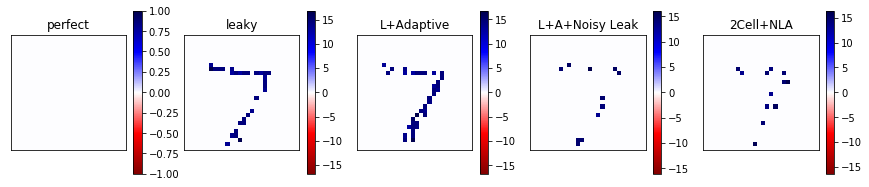

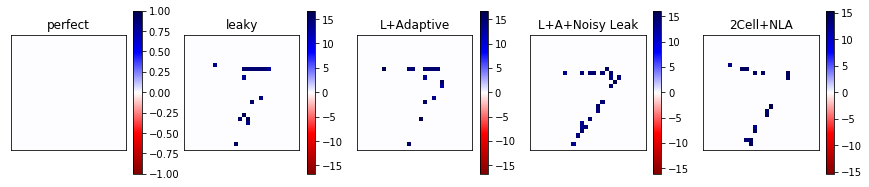

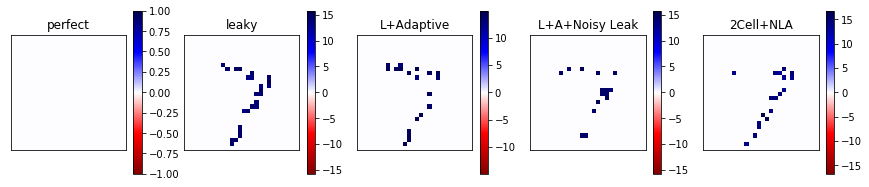

In [4]:
def ishow(ax, image, cmap='gray', vmax=255.):
    if vmax == 0:
        vmax = 1.
    im = ax.imshow(image, cmap=cmap, vmin=-vmax, vmax=vmax)
    ax.set_xticks([])
    ax.set_yticks([])
    return im
    
fw = 3.
num_steps = 10
num_nvs_sims = len(funcs)
thr_base = vmax * 0.05
thr_incr = 1.8 # increase 
thr_leak = np.exp(-1.0/10.0) # revert to base threshold after X frames
leak = np.exp(-1.0/50.0) # completely forget after X frames
leak_prob = 0.7 # how likely should leak be

references = [np.random.uniform(vmin, vmax, size=img.shape) 
              for _ in range(num_nvs_sims)]
thresholds = [np.ones_like(img) * thr_base for _ in range(num_nvs_sims)]
spikes = [np.zeros_like(img) for _ in range(num_nvs_sims)]

reference_off = np.random.uniform(vmin, vmax, size=img.shape)
thresholds_off = np.ones_like(img) * thr_base
target_off = vmax
thresholded_difference(img, references[0], thresholds[0], spikes[0])

for i in range(num_steps):
    fig = plt.figure(figsize=(fw * num_nvs_sims, fw))
    for nvs_type in range(num_nvs_sims):
        args = {
            'frame': img, 
            'reference': references[nvs_type], 
            'thresholds': thresholds[nvs_type],
            'spikes': spikes[nvs_type],
        }
        if nvs_type > 0:
            args['reference_leak'] = leak
        if nvs_type > 1:
            args.update({
                'threshold_base': thr_base,
                'threshold_mult_incr': thr_incr, 
                'threshold_leak': thr_leak
            })
        if nvs_type > 2:
            args['reference_leak_probability'] = leak_prob
        if nvs_type > 3:
            args['reference_off'] = reference_off
            args['thresholds_off'] = thresholds_off
            args['target_off'] = target_off
        
        nvs = funcs[nvs_type](**args)
        
        ax = plt.subplot(1, num_nvs_sims, nvs_type + 1)
        ax.set_title(txt[nvs_type])
        out = spikes[nvs_type]
        im = ishow(ax, out, cmap='seismic_r', vmax=np.abs(out).max())
        plt.colorbar(im)
    plt.show()
    